# Porod subtraction
Author: Eike Gericke \
Scattering curves of particles with sharp interfaces obey to the Porod law for high q-values. \
This means, the scattering intensity decreases proportional to an exponent -a- \
The Exponent -a- is equal -4 for spherical particles and -3 for flat particles. \
The coefficiant -c4- (I(q) = c4 * q^a) is proportional to the inner surface of the scattering structures. 
An additional angle (q-value) independent scattering contribution -c0- is related to e.g. Raman scattering or fluoreszense. \
\
The values -c0- and -c4- can be determiend using this sctipt.\
Knowing the values -c0- is nessesary to later determine the resonant scattering contribution in ASAXS experiments.\

## Libraries

In [1]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

## Job Parameters

In [2]:
# give the metadada directory
data_dir = 'files\Data_for_ASAXS\Corrected_1D\\223_TestPorod'

# give the target file tyle:
target_file_type = 'Norm.dat'

porodFitting = True
plotFitResults = True

# Fitting limits
# for high q regime - using porod like fitting
q_pe_min = 1.5
q_pe_max = 7.0
q_pe_skipPoints = 30 # points to skip at the end indipendent from the actual q-range

# Fit Funktions
c0_start = 0.03
c1_start = 0.003
c4_start = 0.02
a_fix = 4
def porod_ext(x, c0, c1, c4):
    return c0 + c1 * x + c4 * x**(-a_fix)

## Job
### Search the directory

In [3]:
# scan the directory
fileList = list()
for entry in os.scandir(data_dir):
    if entry.path.endswith(target_file_type) and entry.is_file():
        fileList.append(entry.path)

fileIterator = iter(fileList)
dF=pd.DataFrame()
for element in fileIterator: 
    dF = dF.append({'FileName':element.split(os.sep)[-1]},ignore_index=True)

files\Data_for_ASAXS\Corrected_1D\223_TestPorod\223_10000.0_eV_Tif_509_Norm.dat
Optimization range used is: 1.493399742514819  to  6.992165858510892  nm-1 between Index  65  and  338
files\Data_for_ASAXS\Corrected_1D\223_TestPorod\223_7000.0_eV_Tif_383_Norm.dat
Optimization range used is: 1.49656251723462  to  5.331604217676861  nm-1 between Index  97  and  369
files\Data_for_ASAXS\Corrected_1D\223_TestPorod\223_8004.0_eV_Tif_401_Norm.dat
Optimization range used is: 1.5016289965479652  to  6.096302347022435  nm-1 between Index  84  and  369
files\Data_for_ASAXS\Corrected_1D\223_TestPorod\223_8239.0_eV_Tif_419_Norm.dat
Optimization range used is: 1.4959307201048404  to  6.275285101550251  nm-1 between Index  81  and  369
files\Data_for_ASAXS\Corrected_1D\223_TestPorod\223_8304.0_eV_Tif_437_Norm.dat
Optimization range used is: 1.5077324421479668  to  6.324792181287166  nm-1 between Index  81  and  369
files\Data_for_ASAXS\Corrected_1D\223_TestPorod\223_8324.0_eV_Tif_455_Norm.dat
Optimiza

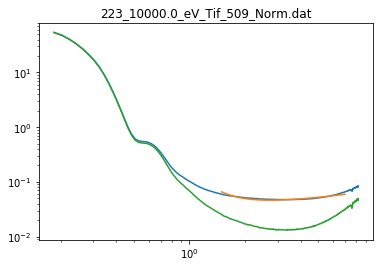

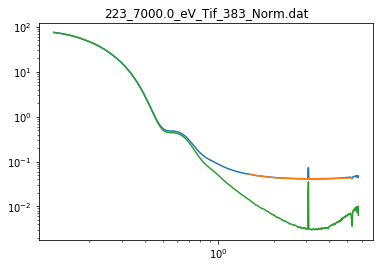

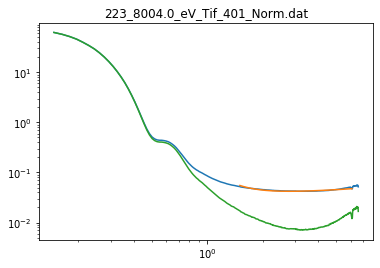

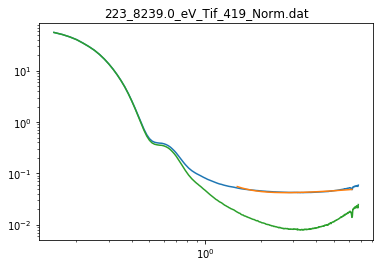

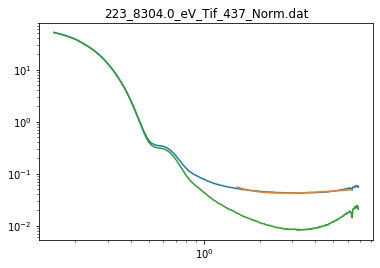

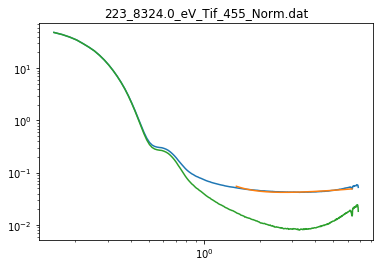

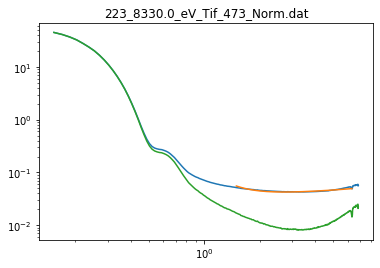

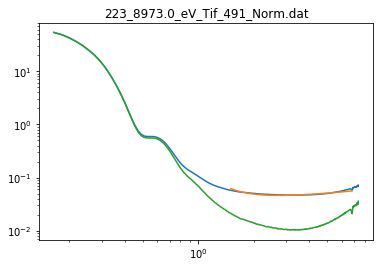

In [5]:
# make an path iterator from the found files
fileIterator = iter(fileList)
dF_pe=pd.DataFrame()

for element in fileIterator:
    q, I, e = np.genfromtxt(element,skip_header=0,unpack=True)
    print(element)
    
    if porodFitting == True: 
        # Define Fitting range
        q_shop = q[:-q_pe_skipPoints]
        q_pe_IndexMin = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_min))
        q_pe_IndexMax = min(range(q_shop.size), key=lambda i: abs(q_shop[i]-q_pe_max))
        print('Optimization range used is:',q[q_pe_IndexMin],' to ',q[q_pe_IndexMax],' nm-1 between Index ',q_pe_IndexMin,' and ',q_pe_IndexMax)
        # Actual Fitting
        popt, pcov =optimize.curve_fit(porod_ext,q[q_pe_IndexMin:q_pe_IndexMax],I[q_pe_IndexMin:q_pe_IndexMax],p0=[c0_start,c1_start,c4_start],sigma=e[q_pe_IndexMin:q_pe_IndexMax])
        # Output Data
        dF_pe = dF_pe.append({'Porod_qMin':q[q_pe_IndexMin],'Porod_qMax':q[q_pe_IndexMax],'c0':popt[0],'c1':popt[1],'c4':popt[2]},ignore_index=True)
        #dF = dF.append(dF_pe)
        # Plotting the result
        if plotFitResults == True:
            I_gen = porod_ext(q[q_pe_IndexMin:q_pe_IndexMax],popt[0], popt[1], popt[2])
            fig, ax = plt.subplots()
            ax.plot(q, I)
            ax.plot(q[q_pe_IndexMin:q_pe_IndexMax], porod_ext(q[q_pe_IndexMin:q_pe_IndexMax],popt[0], popt[1], popt[2]))
            ax.plot(q,I-popt[0])
            plt.title(element.split(os.sep)[-1], fontdict=None, loc='center', pad=None)
            ax.loglog()
        else:
            pass
        I_out=I-popt[0]
        
    
    # Save Numpy array to csv with header    
    save_file_name = element[:-4]+'_c0_Sub'+'.dat'
    file_header = str(element.split(os.sep)[-1])+'\tc0_Subtracted c0=\t'+str(popt[0])+'\n'+'q\tI\tPoisson error\nnm-1\tcm-1\tcm-1'
    np.savetxt(save_file_name, np.column_stack((q, I_out, e)), delimiter='\t', header=file_header)

# Save Pandas Frame to csv with header    
outputFrame = pd.concat([dF,dF_pe],axis=1)
save_outPut_name = data_dir+os.sep+'Porod_logg'+'.txt'
outputFrame.to_csv(save_outPut_name, sep='\t')

In [195]:
outputFrame

,FileName,Porod_qMax,Porod_qMin,c0,c1,c4
0,223_10000.0_eV_Tif_509_Norm.dat,6.992166,1.493400,0.034332,0.003589,0.130496
1,223_7000.0_eV_Tif_383_Norm.dat,5.331604,1.496563,0.037904,0.000937,0.065382
2,223_8004.0_eV_Tif_401_Norm.dat,6.096302,1.501629,0.034979,0.002046,0.086001
3,223_8239.0_eV_Tif_419_Norm.dat,6.275285,1.495931,0.034293,0.002267,0.087786
4,223_8304.0_eV_Tif_437_Norm.dat,6.324792,1.507732,0.034206,0.002366,0.089186
5,223_8324.0_eV_Tif_455_Norm.dat,6.340026,1.494598,0.034202,0.002344,0.086464
6,223_8330.0_eV_Tif_473_Norm.dat,6.344599,1.495676,0.034690,0.002333,0.086175
7,223_8973.0_eV_Tif_491_Norm.dat,6.834365,1.502692,0.036489,0.002896,0.108815
